# Driver Drowsiness Alert System

This Jupyter Notebook implements a real-time driver drowsiness detection system. It uses computer vision techniques to analyze a driver's face from a webcam feed, detects signs of fatigue like closed eyes or yawning, and triggers an alert.


# Overview
This notebook demonstrates three approaches for driver drowsiness detection included in this project:

- Dlib landmarks + EAR/MAR thresholds (lightweight, classic)
- MediaPipe Face Mesh + EAR/MAR (robust, modern)
- CNN classifier (learned model)

Use the sections below to run the approach you prefer. Each section has Image based demo where sample images are used for prediction and live demo using the code to start the webcam loop.

---

# Table of Contents
1. Drowsiness Detection (dlib landmarks)
2. Drowsiness Detection (MediaPipe Face Mesh)
3. Drowsiness Detection (CNN classifier)
4. Log analysis demo
5. Bonus Implementation (Streamlit web application)

---

### Environment setup

You can create and activate a Python virtual environment (`.venv`) and install dependencies, or run the provided helper script. Examples below assume macOS / zsh and Python 3.

Create a virtual environment and install requirements:

```bash
python3 -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

Or run the repository helper script (if present):

```bash
bash ./scripts/setup_venv.sh
```

Notes:
- Use Python 3.8+ where possible.
- If the script requires privileges, review it before running.
- After activating the `.venv`, run the notebook kernel using the same Python interpreter to ensure packages are available.

---

# 1. Drowsiness Detection using dlib landmarks

---

### Image based demo

In [ ]:
# This cell lets you preview the overlay on a static image so you don't need a camera.
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from drowsiness.dlib_analyzer import DlibAnalyzer

analyzer = DlibAnalyzer()
print(analyzer)
# Path to a sample image you can add to the repo (optional)
img_path = 'sample_images/yawn_test.png'

if os.path.exists(img_path):
    img = cv2.imread(img_path)
else:
    # create a simple synthetic placeholder image if no sample image is present
    img = 255 * np.ones((480, 640, 3), dtype=np.uint8)
    cv2.putText(img, 'SAMPLE DRIVER', (40, 240), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 2)

# Run the analyzer (analyzer should already be created above)
try:
    annotated, is_drowsy, is_yawning = analyzer.analyze(img.copy())
except Exception as e:
    print('Error during analysis:', e)

# Convert BGR->RGB for inline display
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 7))
plt.imshow(annotated_rgb)
plt.axis('off')
plt.show()

print('Drowsy:', is_drowsy, 'Yawning:', is_yawning)

: 

 ### WebCam Demo (dlib landmarks) (press q to quit demo)
 This run uses the classic dlib-based landmark detector via `DrowsinessAnalyzer.analyze_frame`. It opens a webcam stream, overlays EAR/MAR and alerts, and keeps the window responsive until you press `q`. Use this when you want the lightest dependency set (no MediaPipe).

In [15]:
from drowsiness.utils import run_drowsiness_detection_loop
from drowsiness.dlib_analyzer import DlibAnalyzer

# Run the detection loop with dlib-based analyzer
analyzer = DlibAnalyzer()
run_drowsiness_detection_loop(
    analyzer=analyzer,
    window_name="Drowsiness Detection"
)

---

# 2. Drowsiness Detection (MediaPipe Face Mesh)

---

### Image based demo

I0000 00:00:1766011059.141286 15089631 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2 Pro
W0000 00:00:1766011059.143400 15263034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766011059.168907 15263038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/kedar/Documents/pyproj/driver-drowsiness-detection/.venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


BaseAnalyzer(EAR_Threshold=0.2, EAR_Frames=20, MAR_Threshold=0.5)


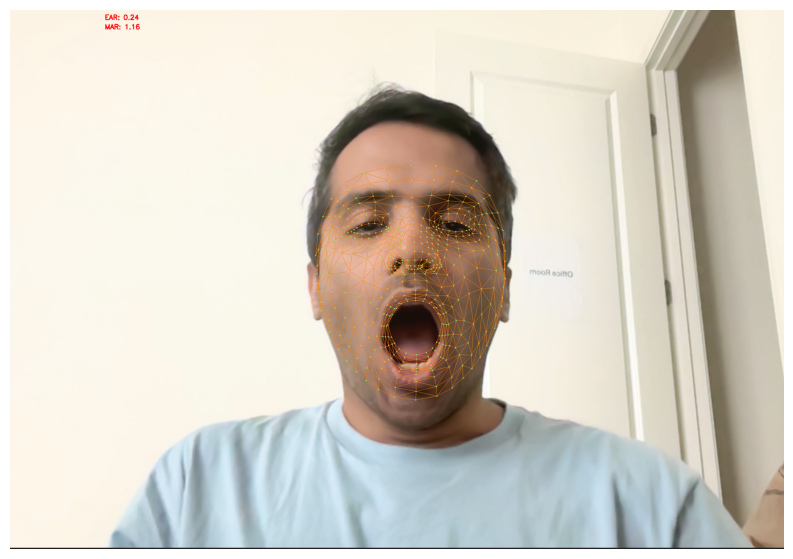

Drowsy: False Yawning: False


In [16]:
# This cell lets you preview the overlay on a static image so you don't need a camera.
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from drowsiness.mediapipe_analyzer import MediapipeAnalyzer

# Initialize analyzers
analyzer = MediapipeAnalyzer()
print(analyzer)
# Path to a sample image you can add to the repo (optional)
img_path = 'sample_images/yawn_test.png'

if os.path.exists(img_path):
    img = cv2.imread(img_path)
else:
    # create a simple synthetic placeholder image if no sample image is present
    img = 255 * np.ones((480, 640, 3), dtype=np.uint8)
    cv2.putText(img, 'SAMPLE DRIVER', (40, 240), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 2)

# Run the analyzer (analyzer should already be created above)
try:
    annotated, is_drowsy, is_yawning = analyzer.analyze(img.copy())
except Exception as e:
    print('Error during analysis:', e)

# Convert BGR->RGB for inline display
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 7))
plt.imshow(annotated_rgb)
plt.axis('off')
plt.show()

print('Drowsy:', is_drowsy, 'Yawning:', is_yawning)

### WebCam demo
This variant uses MediaPipe Face Mesh to get landmarks, then `DrowsinessAnalyzer.analyze_frame_mediapipe` for EAR/MAR, overlay, and logging. It mirrors the frame for a user-facing preview and shares the same capture/cleanup helper.

In [1]:
from drowsiness.mediapipe_analyzer import MediapipeAnalyzer
from drowsiness.utils import run_drowsiness_detection_loop

# Initialize analyzers
mediapipe_analyzer = MediapipeAnalyzer()

# Run the detection loop with MediaPipe analyzer

run_drowsiness_detection_loop(
    analyzer=mediapipe_analyzer,
    window_name="Drowsiness Detection (MediaPipe)"
)

I0000 00:00:1766011086.327027 15263665 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1766011086.328638 15263811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766011086.330945 15263810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/kedar/Documents/pyproj/driver-drowsiness-detection/.venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


---

# 3. Drowsiness Detection (CNN classifier)

---

### Training the CNN model 
can be skipped, since pre trained model using this method is available in models folder.

### CNN Model training (can skip this, pre trained weights available in models folder)

Processing yawn...
Processing no_yawn...
Processing Closed...
Processing Open...
Epoch 1/50


/Users/kedar/Documents/pyproj/driver-drowsiness-detection/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 811ms/step - accuracy: 0.4445 - loss: 1.2389 - val_accuracy: 0.6059 - val_loss: 0.9493
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 809ms/step - accuracy: 0.7215 - loss: 0.7258 - val_accuracy: 0.8316 - val_loss: 0.4914
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 833ms/step - accuracy: 0.7870 - loss: 0.5335 - val_accuracy: 0.8507 - val_loss: 0.4349
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 845ms/step - accuracy: 0.8392 - loss: 0.4118 - val_accuracy: 0.8611 - val_loss: 0.4101
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 813ms/step - accuracy: 0.8340 - loss: 0.4514 - val_accuracy: 0.8698 - val_loss: 0.3968
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 811ms/step - accuracy: 0.8541 - loss: 0.3940 - val_accuracy: 0.8941 - val_loss: 0.3334
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 809ms/step - accuracy: 0.8764 - loss: 0.3338 - val_accuracy: 0.9097 - val_loss: 0.2862
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 812ms/step - accuracy: 0.8920 - loss: 0.2731 - val_accuracy: 0.911

Training history plot saved to models/training_history.png


(<Sequential name=sequential, built=True>,
 <keras.src.callbacks.history.History at 0x14ba74da0>)

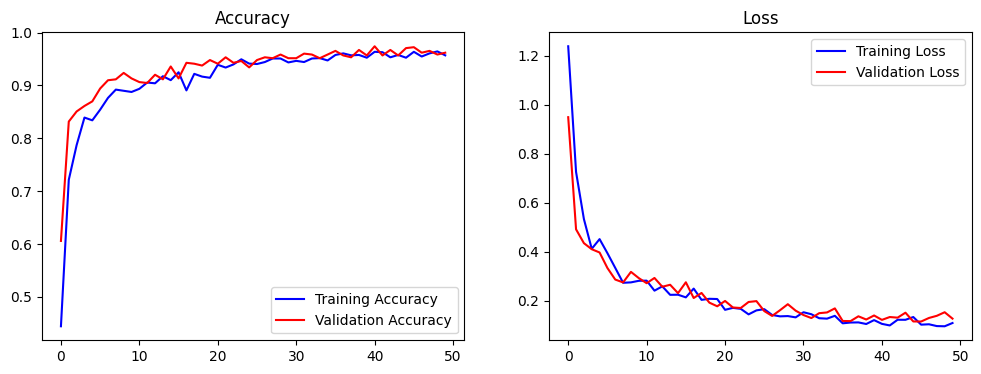

In [12]:
# Train the CNN model
from drowsiness.cnn_trainer import CNNTrainer

# This will download the dataset if needed, preprocess it, train the CNN, and save the model.
trainer = CNNTrainer()
trainer.train(epochs=50, batch_size=32)

### Image based demo

/Users/kedar/Documents/pyproj/driver-drowsiness-detection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model from models/drowsiness_cnn.h5...
BaseAnalyzer(EAR_Threshold=0.2, EAR_Frames=20, MAR_Threshold=0.5)


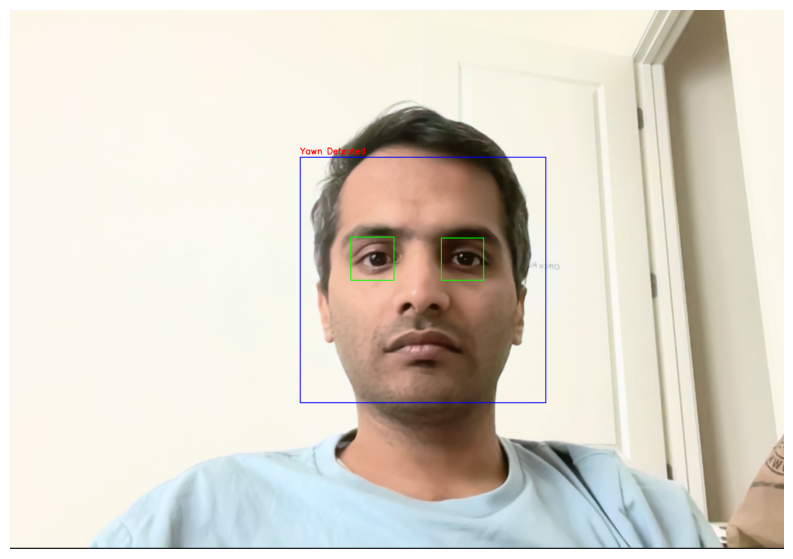

Drowsy: False Yawning: True


In [2]:
# This cell lets you preview the overlay on a static image so you don't need a camera.
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from drowsiness.cnn_analyzer import CnnAnalyzer

# Initialize analyzers
analyzer = CnnAnalyzer()
print(analyzer)
# Path to a sample image you can add to the repo (optional)
img_path = 'sample_images/active_test.png'

if os.path.exists(img_path):
    img = cv2.imread(img_path)
else:
    # create a simple synthetic placeholder image if no sample image is present
    img = 255 * np.ones((480, 640, 3), dtype=np.uint8)
    cv2.putText(img, 'SAMPLE DRIVER', (40, 240), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 2)

# Run the analyzer (analyzer should already be created above)
try:
    annotated, is_drowsy, is_yawning = analyzer.analyze(img.copy())
except Exception as e:
    print('Error during analysis:', e)

# Convert BGR->RGB for inline display
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 7))
plt.imshow(annotated_rgb)
plt.axis('off')
plt.show()

print('Drowsy:', is_drowsy, 'Yawning:', is_yawning)

### WebCam demo
This pipeline uses the trained CNN model (`CNNDrowsinessDetector`) to classify frames as drowsy/yawning and reuses the same webcam loop helper. Use this when you want a learned model instead of landmark thresholds.

In [6]:
from drowsiness.cnn_analyzer import CnnAnalyzer
from drowsiness.utils import run_drowsiness_detection_loop

# Run the detection loop with dlib-based analyzer
detector = CnnAnalyzer('models/drowsiness_cnn_trained.h5')
run_drowsiness_detection_loop(
    analyzer=detector,
    window_name="Drowsiness Detection"
)

Loading model from models/drowsiness_cnn_trained.h5...


---

# 4. Logs analysis of previously scanned history

---

Loaded 67 events from logs/drowsiness_log.csv
Total events: 67
2025-11-14: Yawn Detected: 11, Drowsiness Detected: 20
2025-11-23: Drowsiness Detected: 1, Yawn Detected: 1
2025-12-13: Yawn Detected: 5, Drowsiness Detected: 4
2025-12-16: Drowsiness Detected: 9, Yawn Detected: 3
2025-12-17: Drowsiness Detected: 9, Yawn Detected: 4


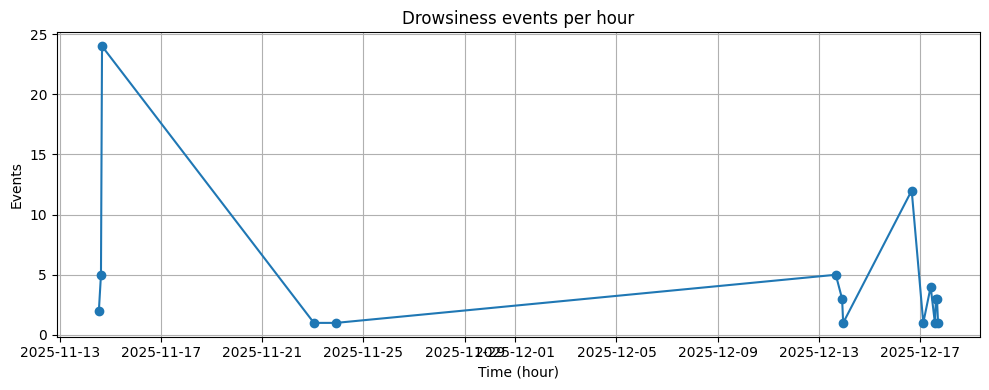

Most recent event: 2025-12-17 17:38:09 Yawn Detected
No screenshot available for this event.


In [4]:
# Log analysis demo: read logs, print a summary, plot timeline, and show latest thumbnail (if available)
from tools import log_analysis

log_file = 'logs/drowsiness_log.csv'
events = log_analysis.read_logs(log_file)

print('Loaded', len(events), 'events from', log_file)

# Print a compact summary
log_analysis.print_summary(events)

# If matplotlib is available, plot a simple timeline
try:
    log_analysis.plot_timeline(events)
except Exception as e:
    print('Plotting unavailable or failed:', e)

# Show the thumbnail for the most recent event if one exists
if events:
    latest = events[-1]
    print('Most recent event:', latest['timestamp'].strftime('%Y-%m-%d %H:%M:%S'), latest['event'])
    try:
        log_analysis.show_event_thumbnail(latest)
    except Exception as e:
        print('Thumbnail display unavailable or failed:', e)
else:
    print('No events found in the log file.')


---

# 5. Streamlit App (Bonus Implememtation)

### Developed a Streamlit webapp to Detect drowsy state using browser. Switch between those methods in browser in left pane drop down

---

In [ ]:
! streamlit run app.py --server.headless true


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.86.30:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
^C
  Stopping...
Exception ignored in: <module 'threading' from '/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py'>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py", line 1594, in _shutdown
    atexit_call()
  File "/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/concurrent/futures/thread.py", line 31, in _python_exit
    t.join()
  File "/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py", line 1149, in join
    self._wait_for_tstate_lock()
  File "/opt/homebrew